In [194]:
import numpy as np
# import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pickle

import train_lstm
import models
import lstm_xai

In [153]:
import importlib

importlib.reload(train_lstm)
importlib.reload(models)
importlib.reload(lstm_xai)

<module 'lstm_xai' from 'C:\\Users\\jakub\\Documents\\DATA\\Indv_proj\\code\\lstm_xai.py'>

In [3]:
seed = 1289719
series_min_len = 144 #12hrs
pred_horizon = 12 # 1hr
input_size = series_min_len - pred_horizon
output_size = pred_horizon
batch_size = 128
learning_rate = 0.01

# Hyper-parameters
hidden_size = 8 #The number of features in the hidden state h
num_layers = 3 #number of stacked layers
drop_out = 0

device = torch.device('cpu')
lstm_trainer = train_lstm.LSTM_Trainer(seed, device)


In [195]:
# Load Dataset
dataset_path = "timeseries_all-patients_step-1_len-6391075.pkl"
[X_train, X_test, y_train, y_test] = pickle.load(open(dataset_path, 'rb'))

In [141]:
# Load Model
lstm = models.LSTM(1, 1, num_layers, hidden_size, drop_out, learning_rate).to(device)
loss_func = nn.MSELoss()
optimizer= torch.optim.Adam(lstm.parameters(), lr=learning_rate)
# optimiser = optim.LBFGS(model.parameters(), lr=0.08)
lstm_trainer.set_model(lstm, loss_func, optimizer)

model_name = "saves/all_data/lstm_hid8_layer3_drop0_8.pt"
epoch_start = lstm_trainer.load_weights(model_name)

## XAI

[9.78032247e-02 1.05559515e-05 8.86068195e-01 9.92769842e-01
 4.65373404e-03 5.36063220e-05 9.17296904e-01 1.75588289e-03]
[7.47849625e-01 8.58795056e-05 2.30049497e-01 9.99993872e-01
 1.16211139e-01 8.26783226e-02 9.98313654e-01 9.99935429e-01]
[4.34251631e-01 1.58743663e-05 1.44837309e-02 9.96105351e-01
 2.44985253e-06 1.97380199e-02 7.76289279e-01 1.58816318e-04]
[1.16199672e-01 2.18135582e-05 7.40969599e-03 9.13822319e-01
 1.79047563e-08 1.45020272e-02 4.32900127e-01 2.56369149e-07]
[8.65514708e-02 9.42546654e-05 1.26083618e-02 8.67825586e-01
 2.21130862e-10 6.79082543e-03 4.70618516e-01 6.70099640e-07]
[1.33935014e-01 1.64420196e-03 5.12935211e-02 8.83159803e-01
 4.88941105e-12 6.71752020e-04 8.70373426e-01 1.10192413e-08]
[1.79080085e-01 6.19423332e-03 1.89100903e-01 9.84931845e-01
 4.73061950e-10 9.78963325e-05 9.86887601e-01 7.16120287e-08]
[2.99521264e-01 2.83580101e-02 2.21273303e-01 9.99448271e-01
 1.24511512e-07 3.58129598e-05 9.97962976e-01 5.33686851e-07]
[2.82846890e-01 

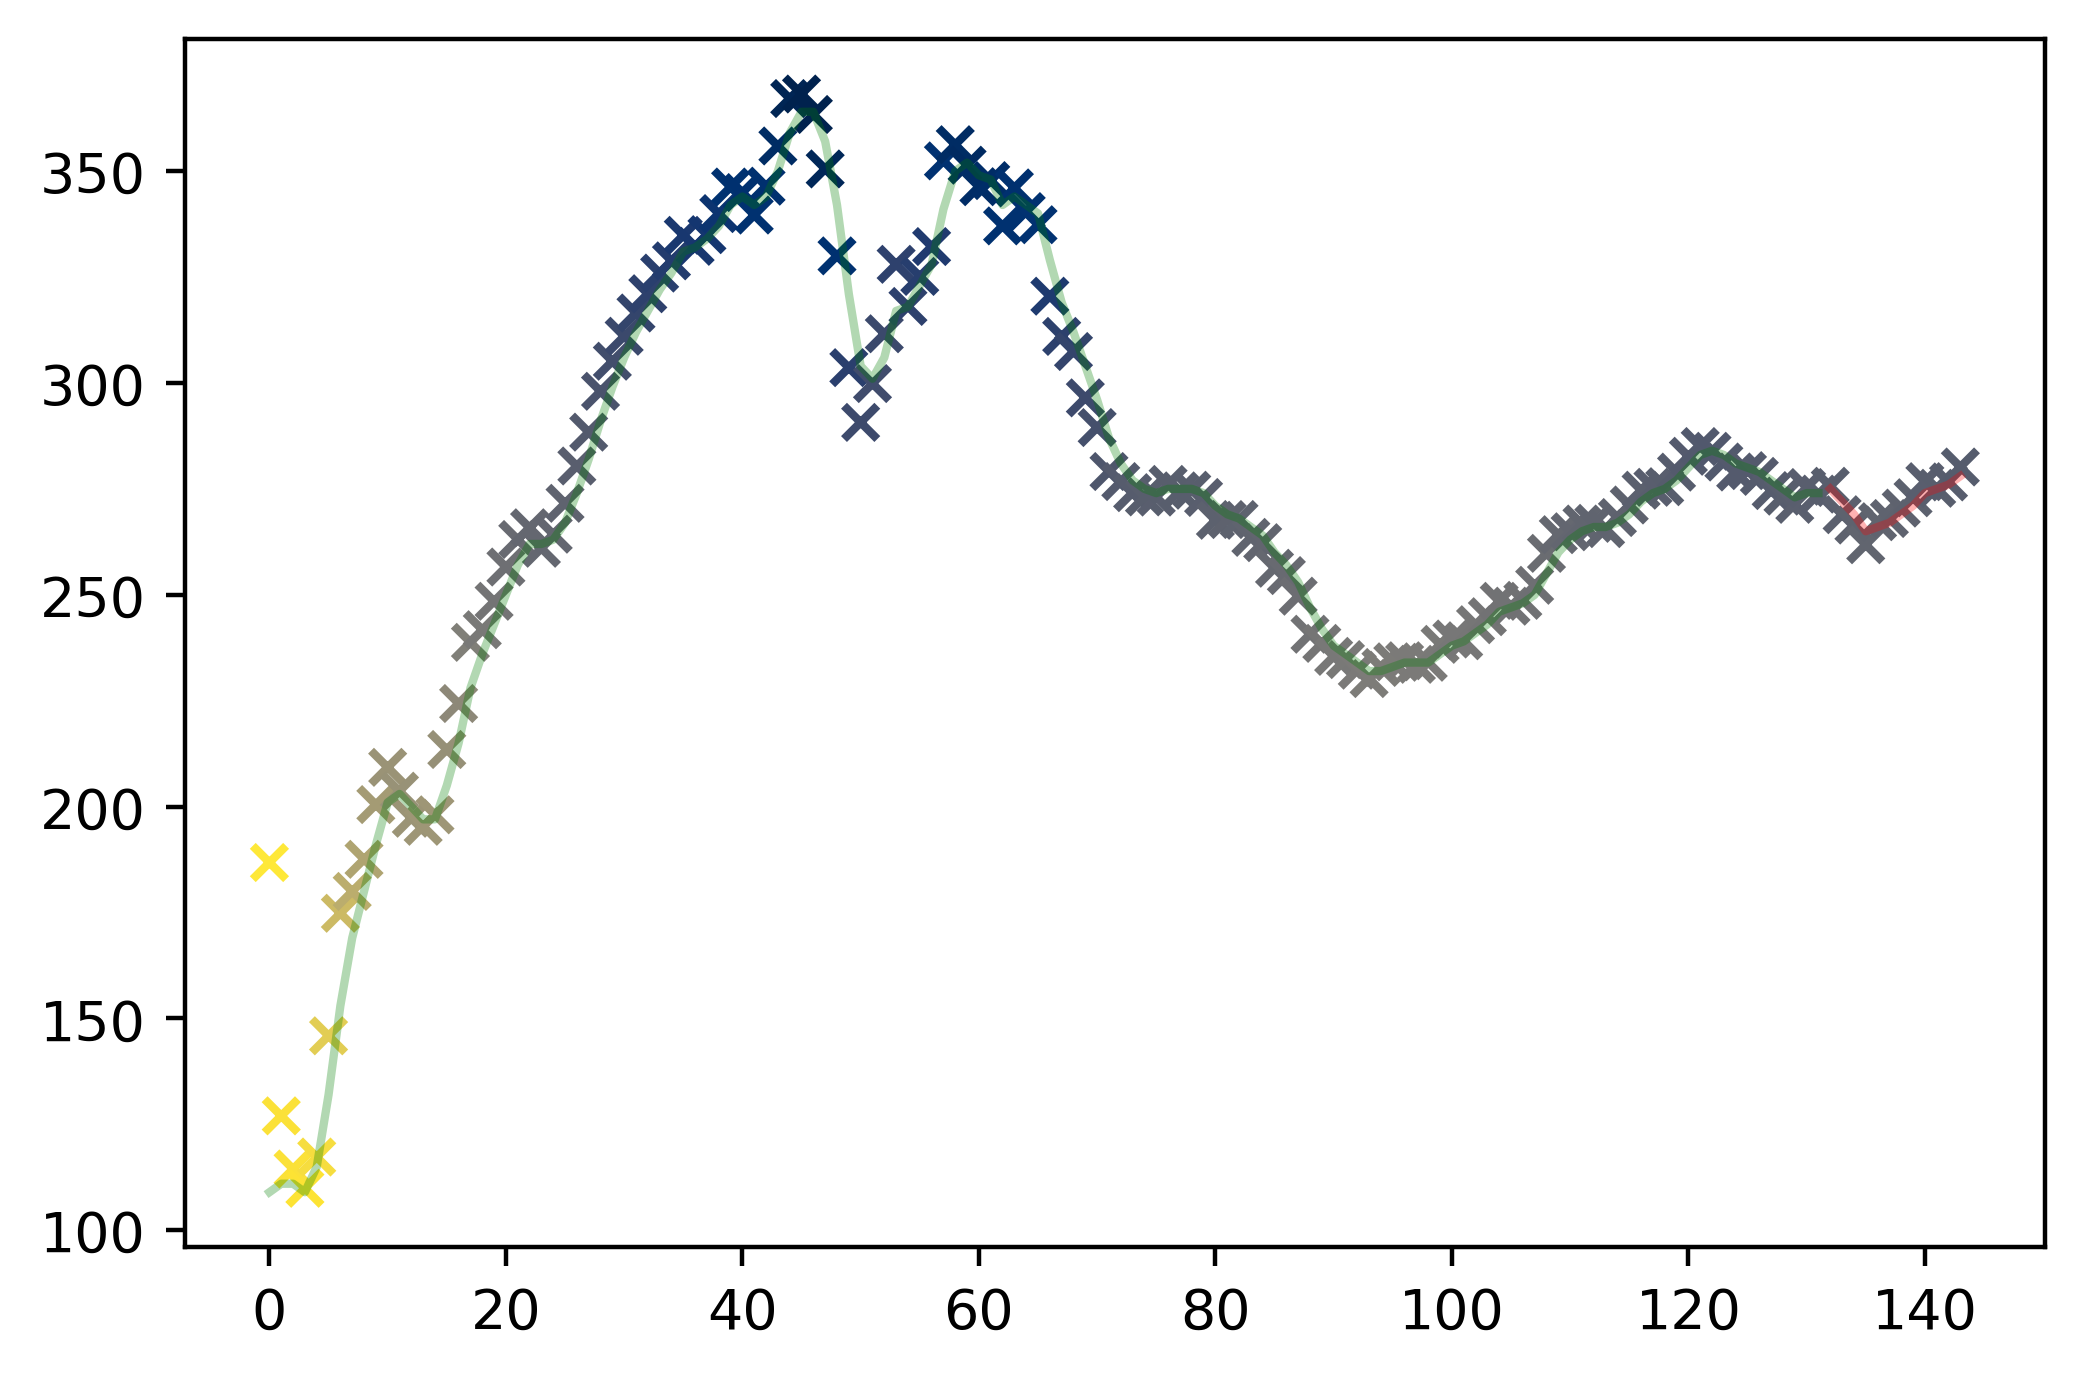

In [328]:
index = 100
X = X_test[index].squeeze()
y = y_test[index].squeeze()


state = lstm.state_dict()

layer0 = lstm_xai.lstm_layer(hidden_size, state, 0)
layer1 = lstm_xai.lstm_layer(hidden_size, state, 1)
layer2 = lstm_xai.lstm_layer(hidden_size, state, 2)

out_pred = []
out_fg0 = []
out_fg1 = []
out_fg2 = []

data = np.append(X, y)

for x in data:
    x = [x]
    h0, c0, fg0 = layer0.forward(x, layer0.h)
    # print("h0", h0)

    h1, c1, fg1 = layer1.forward(h0, layer1.h)
    # print("h1", h1)

    h2, c2, fg2 = layer2.forward(h1, layer2.h)
    # print("h2", h2)

    pred0 = lstm_xai.model_output(h0, layer0.fc_Weight, layer0.fc_Bias)
    pred1 = lstm_xai.model_output(h1, layer0.fc_Weight, layer0.fc_Bias)
    pred2 = lstm_xai.model_output(h2, layer0.fc_Weight, layer0.fc_Bias)

    out_pred.append(pred2)
    print(fg2)
    out_fg0.append(fg0[0]+fg0[3])
    out_fg1.append(np.mean(fg1))
    out_fg2.append(np.mean(fg2))
    # print("x", x, " pred", pred0, pred1, pred2)


out_pred = [round(num, 5) for num in out_pred]
out_pred = np.asarray(out_pred)

# print(out_fg0)
print(max(out_fg0), min(out_fg0))
# out_fg0 = (out_fg0 - np.min(out_fg0))/np.ptp(out_fg0)
out_fg0 = np.log(out_fg0) # log as numbers so small cannot display
print(out_fg0)

plt.figure(dpi=400)
plt.plot(range(0,input_size), data[:input_size], color='green', alpha=0.3)
plt.plot(range(input_size,series_min_len), data[-pred_horizon:], color='red', alpha=0.3)
# plt.scatter(range(0,input_size), out_pred[:input_size], marker='x', c=out_fg2[:input_size], cmap='cividis')
# plt.scatter(range(input_size,series_min_len), out_pred[-pred_horizon:], marker='+', c=out_fg2[-pred_horizon:], cmap='cividis')
plt.scatter(range(0,series_min_len), out_pred, marker='x', c=out_fg0, cmap='cividis')

## PyTorch check

torch.Size([1, 132, 1])
[213.14212  76.78785  60.58916  69.69936  73.82855  76.19746  72.81453
  75.95337  85.91726  88.65402  90.96257  95.8625   95.86451  95.74938
 101.44718 108.58019 118.5731  123.47726 126.20893 130.29802 126.50593
 122.88797 123.75777 130.991   144.0493  163.74317 182.03373 203.25451
 231.98618 250.72911 267.73559 281.58708 299.8614  314.57348 324.07926
 320.50331 311.22429 303.1926  296.58767 295.53228 292.82314 288.87064
 290.05044 288.72533 289.32431 287.41316 286.48106 283.64243 277.56205
 272.26031 267.83729 269.11497 266.18897 261.46792 255.09234 250.76908
 245.9359  238.17606 230.71576 222.34284 207.71235 195.77152 182.31501
 169.36415 158.36711 144.13924 131.40648 118.72573 109.36341 100.53513
  91.16329  82.96977  77.37191  71.84204  70.07242  67.70963  66.49917
  68.80093  70.40999  77.50338  84.73576  96.24016 110.77406 125.3269
 143.00811 151.57528 171.9139  187.73766 208.75814 229.42964 247.03705
 259.8338  259.89694 251.99242 238.03465 232.27321 239

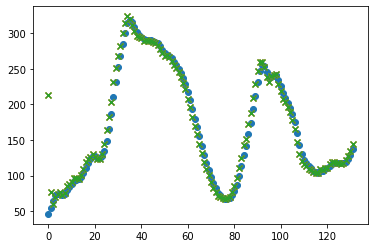

In [193]:
X_t = torch.tensor([X]).float()
X_t = torch.reshape(X_t, (1, input_size, 1))
print(X_t.shape)

weight = next(lstm.parameters()).data
hidden = (weight.new(lstm.num_layers, 1, lstm.hidden_size).zero_(),
          weight.new(lstm.num_layers, 1, lstm.hidden_size).zero_())

# hidden = lstm.init_hidden(1)

# print(type(hidden))
# print(type(hidden[0]))
# print(hidden[0])
# print(type(hidden[1]))
# print(hidden[1])
#
# hidden[0][0] = hidden[0][0].to(device)

out_torch, out_hidden = lstm(X_t, hidden)
out_torch = out_torch.detach().numpy().squeeze()

plt.scatter(range(0,132), X, marker='o')
plt.scatter(range(0,132), out_pred, marker='x')
plt.scatter(range(0,132), out_torch , marker='x')


print(out_pred)
print(out_torch)
print(out_torch - out_pred)
